In [93]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
from gurobipy import GRB, quicksum
import torch

class QuadraticObj:
    
    def __init__(self, d=20, hidden_d=2):
        self.dim = d
        self.quadratic = np.random.rand(d,2)
        self.quadratic = np.matmul(self.quadratic, self.quadratic.T)
        self.linear = np.random.rand(d,1)
    
    def value_oracle(self, x):
        x_re = x.reshape(1,self.dim)
        obj = np.matmul(np.matmul(x_re,self.quadratic), x_re.T) #+ np.matmul(x_re, self.linear)
        return obj[0][0]
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.reshape(1,self.dim) for x in x_list]
        value_list = [(np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear))[0][0] for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):   
        tensor_x = torch.tensor(x, requires_grad = True)
        x_re = tensor_x.reshape(1,self.dim)
        obj = torch.matmul(torch.matmul(x_re,torch.tensor(self.quadratic)), x_re.T) + torch.matmul(x_re, torch.tensor(self.linear))
        obj.backward()
        return tensor_x.grad.numpy()

In [94]:
dim  = 2
objective = QuadraticObj(d=dim,hidden_d=dim//2)

In [95]:
initial = np.random.randn(objective.dim) +20
total_steps = 30
reps = 1
line_search = 4
query_num = 2

In [96]:


def grad_est_from_rank_es_like(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
    relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
    weight = np.sign(relative_rank - relative_rank[0]) #* np.power(np.abs(relative_rank - relative_rank[0]),0)
    #print(weight)
    
    grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))],axis=0)
    
    return grad_est/np.linalg.norm(grad_est) if np.linalg.norm(grad_est)>1e-4 else grad_est

total_zo_rank_es_like_hist = []

zo_rank_grad_es_like_hist = []

moving_list_es = [initial.copy()]
for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)

    top = query_num+1
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_rank_es_like_hist= []

    with_order = True

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, top)
        grad_est = grad_est_from_rank_es_like(query_list,query_rank,sparsity,mu,with_order)
        
        true_grad = objective.gradient_oracle(query_list[query_rank[0]])
        true_grad /= np.linalg.norm(true_grad)
        zo_rank_grad_es_like_hist.append(np.dot(grad_est,true_grad))
        
        line_search = 10
        if line_search > 0:
            line_search_candidates = [query_list[query_rank[0]] - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            x = line_search_candidates[objective.rank_oracle(line_search_candidates)[0]]
        else:
            x = query_list[query_rank[0]] - lr * grad_est
        cur_obj = objective.value_oracle(x)
        moving_list_es.append(x)
        zo_rank_es_like_hist.append(cur_obj)
    total_zo_rank_es_like_hist.append(zo_rank_es_like_hist)

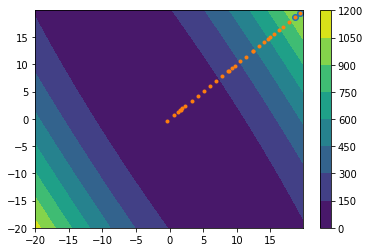

In [99]:
plt.plot([p[0] for p in moving_list_es[:2]],[p[0] for p in moving_list_es[:2]],"o")
plt.plot([p[0] for p in moving_list_es],[p[0] for p in moving_list_es],".")

feature_x = np.arange(-20, 20, 0.1)
feature_y = np.arange(-20, 20, 0.1)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
plt.contourf(X,Y,np.array([[objective.value_oracle(np.array([feature_x[ii],feature_y[jj]])) for ii in range(len(feature_x))] for jj in range(len(feature_x))]))
plt.colorbar()

In [78]:
cur_obj

0.29343333258061577

In [79]:
zo_rank_es_like_hist

[658.4849780965187,
 644.242863718661,
 629.5205902789785,
 617.8216183496871,
 603.95573087804,
 595.8952768905312,
 589.8381266432579,
 578.4669718216774,
 563.0686452525781,
 550.9974106570734,
 536.2684703211879,
 522.6576328697743,
 512.0757940720656,
 498.4352786843958,
 488.34274135215753,
 474.55676215994424,
 465.64655304108777,
 456.0104215570799,
 449.43733665279916,
 440.8733938487825,
 436.8569243202757,
 423.4521068493172,
 414.8749959287237,
 410.6554745625798,
 399.36480388687414,
 390.5494684403445,
 379.13109854731044,
 370.3516763007289,
 363.1052950056365,
 352.66323698855604,
 341.8924181057405,
 334.6521648353536,
 322.7105926266655,
 311.7892290913443,
 300.68222424254753,
 291.59809366916477,
 280.85325772522475,
 270.04029016364285,
 265.1665408360982,
 257.16863963056073,
 249.73875645041744,
 240.1136408359536,
 232.50601632848452,
 225.89790177069946,
 216.5586334661134,
 207.04894426222518,
 197.8260667320081,
 189.58394371092373,
 181.84586366665053,
 174.